# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler 

batch_size= 20
valid_data_size = 0.2

data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


train_transform = transforms.Compose([transforms.Resize(224), 
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0, 0, 0), (1, 1, 1))])

non_train_transform = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0, 0, 0), (1, 1, 1))])

train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(train_dir, transform = non_train_transform)
test_data = datasets.ImageFolder(test_dir, transform = non_train_transform)

# get all the image indices in random order
train_data_size = len(train_data)
test_data_size = len(test_data)
randomized_image_indices = list(range(train_data_size))
np.random.shuffle(randomized_image_indices)

# split train indices and validation indices
split = int(np.floor(valid_data_size * train_data_size))
train_idx, valid_idx = randomized_image_indices[split:], randomized_image_indices[:split]

validation_data_size = len(valid_idx)

# create the data subsets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# load the data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,sampler=valid_sampler, num_workers=0)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

# put data in loader_scratch
loaders_scratch = {'train':train_loader,'valid': valid_loader, 'test':test_loader }

classes = [classes_name.split(".")[1] for classes_name in train_data.classes]

print('Training images: ', train_data_size)
print('Test images: ', test_data_size)
print('Validation images: ', validation_data_size)
print('Classes: ', len(classes))

Training images:  4996
Test images:  1250
Validation images:  999
Classes:  50


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- How does your code resize the images (by cropping, stretching, etc)? 
  What size did you pick for the input tensor, and why?
  
- Answer: It performs resizing and center cropping operation. I picked 224. For me 224 looks like a fare size as I am planning to use Vgg16 for transfer learning.
- Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?
- I am using random flip and ramdom rotation to enhance accuracy of the model

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

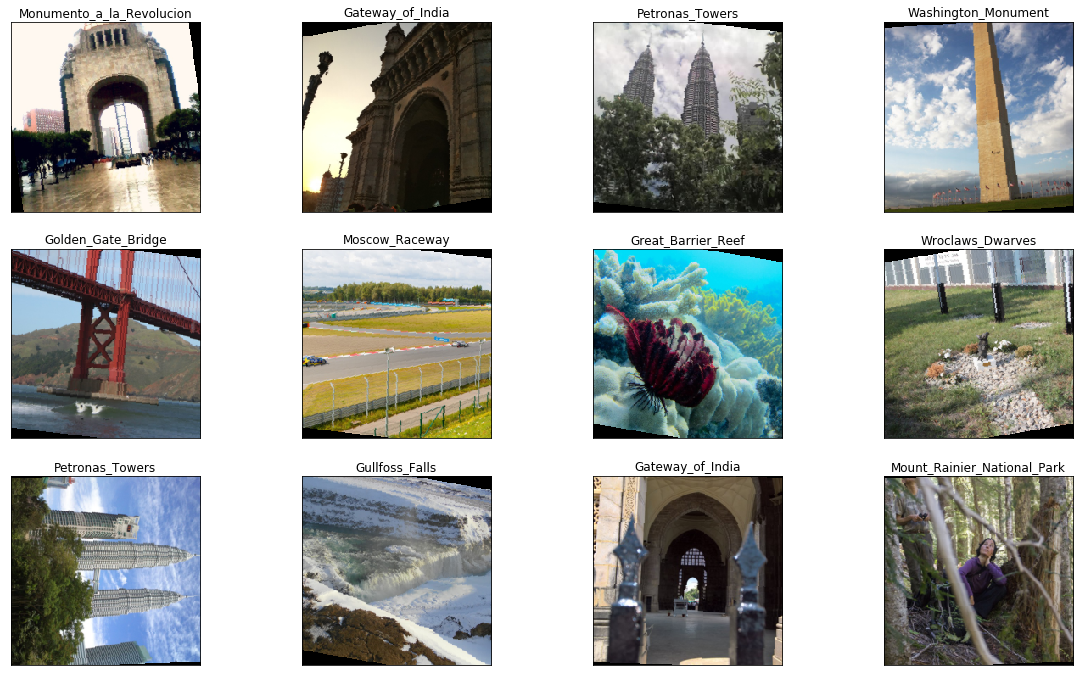

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random


## TODO: visualize a batch of the train data loader
fig = plt.figure(figsize=(20, 2*8))
for index in range(12):
    ax = fig.add_subplot(4, 4, index+1, xticks=[], yticks=[])
    rand_img = random.randint(0, len(train_data))
    
    img = train_data[rand_img][0]
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
import torch.optim as optim
import torch.nn as nn

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.003)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # convolutional layer (uses 224x224x3 image tensor)
        # study: what is kernel size?
        
        # input : 3, output: 16, use filter size: 3x3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        
        # input : 16, output: 32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # input: 32, output: 64
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        
        # max pooling with 2x2 filter
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # reduce image size by 2 (stride size)
        
        # fully connected linear layer (input: 64 * 28 * 28, output: 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        
        # fully connected linear layer (input: 500, output: 50)
        self.fc2 = nn.Linear(500, 50) 
        
        # define dropout
        self.dropout = nn.Dropout(0.25)        
    
    
    
    def forward(self, x):
        ## Define forward behavior
        x=self.pool(F.relu(self.conv1(x)))        
        x=self.pool(F.relu(self.conv2(x)))        
        x=self.pool(F.relu(self.conv3(x)))
        
        # not sure yet, why using -1 worked, inferred shape?
        x=x.view(-1,64*28*28)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print (model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

Here are the steps

- Define convolutional layers
- Define Pooling layer
- Define dropout layers
- Define linear layers
- Reasoning: Tried with 3 convolutional lauers and 0.03 learn rate with 0.20 dropout and got about 21% accuracy. But validation loss did not decrease after about 20 epoch. Wondering if I should reduce the number of epochs or anything else.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # numpy infinity
    
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print ("---n_epochs---")
        print(epoch)
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']): ##### batch_idx is the index, (data,target) is the value
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## print (batch_idx)

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            ####### clear the gradients of all optimized variables
            optimizer.zero_grad()
            output = model(data) # run forward
            loss = criterion(output, target) # calculate loss
            loss.backward() # backpropagation
            optimizer.step() 
            # update training loss
            ###### train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
                       
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        
        ######## Enumerate() method adds a counter to an iterable and returns it in
        ######## a form of enumerating object. 
        ######## This enumerated object can then be used directly for loops or converted 
        ######## into a list of tuples using the list() method.
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data) ###### for each image in validation set, calculate the prediction
            loss = criterion(output, target) ##### calculate the loss between output and target
            # update average validation loss 
            ## valid_loss += loss.item()*data.size(0)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))    
    
        # calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
             ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss       
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

---n_epochs---
1
Epoch: 1 	Training Loss: 0.000979 	Validation Loss: 0.003915
Validation loss decreased (inf --> 0.003915).  Saving model ...
---n_epochs---
2
Epoch: 2 	Training Loss: 0.000979 	Validation Loss: 0.003915
Validation loss decreased (0.003915 --> 0.003915).  Saving model ...
---n_epochs---
3
Epoch: 3 	Training Loss: 0.000978 	Validation Loss: 0.003913
Validation loss decreased (0.003915 --> 0.003913).  Saving model ...
---n_epochs---
4
Epoch: 4 	Training Loss: 0.000978 	Validation Loss: 0.003911
Validation loss decreased (0.003913 --> 0.003911).  Saving model ...
---n_epochs---
5
Epoch: 5 	Training Loss: 0.000977 	Validation Loss: 0.003908
Validation loss decreased (0.003911 --> 0.003908).  Saving model ...
---n_epochs---
6
Epoch: 6 	Training Loss: 0.000975 	Validation Loss: 0.003901
Validation loss decreased (0.003908 --> 0.003901).  Saving model ...
---n_epochs---
7
Epoch: 7 	Training Loss: 0.000973 	Validation Loss: 0.003889
Validation loss decreased (0.003901 --> 0.003

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 75

#-#-# Do NOT modify the code below this line. #-#-#
# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


---n_epochs---
1
Epoch: 1 	Training Loss: 0.000979 	Validation Loss: 0.003915
Validation loss decreased (inf --> 0.003915).  Saving model ...
---n_epochs---
2
Epoch: 2 	Training Loss: 0.000978 	Validation Loss: 0.003913
Validation loss decreased (0.003915 --> 0.003913).  Saving model ...
---n_epochs---
3
Epoch: 3 	Training Loss: 0.000977 	Validation Loss: 0.003910
Validation loss decreased (0.003913 --> 0.003910).  Saving model ...
---n_epochs---
4
Epoch: 4 	Training Loss: 0.000976 	Validation Loss: 0.003905
Validation loss decreased (0.003910 --> 0.003905).  Saving model ...
---n_epochs---
5
Epoch: 5 	Training Loss: 0.000974 	Validation Loss: 0.003893
Validation loss decreased (0.003905 --> 0.003893).  Saving model ...
---n_epochs---
6
Epoch: 6 	Training Loss: 0.000969 	Validation Loss: 0.003870
Validation loss decreased (0.003893 --> 0.003870).  Saving model ...
---n_epochs---
7
Epoch: 7 	Training Loss: 0.000961 	Validation Loss: 0.003830
Validation loss decreased (0.003870 --> 0.003

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.104564


Test Accuracy: 24% (307/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
print(loaders_transfer )


# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)
# print out the model structure
print(model_transfer)


{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f3046c21ba8>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f3047b8bc50>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f3098756128>}


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 116663051.80it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [14]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model_transfer.classifier.parameters(), lr=0.001)    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
## TODO: Specify model architecture
model_transfer.parameters()

for param in model_transfer.features.parameters(): 
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

last_layer = nn.Linear(n_inputs, 50)

model_transfer.classifier[6] = last_layer



#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I have decided to use the vgg16 model. I updated the last hidden layer of the model to match with my number of output classes. This dataset has lot of images and output is similar to vgg16. I have also resized the image to match vgg16 input. So I thought vgg will be suitable for this problem.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        # set the module to training mode
        
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ##print (batch_idx)

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            ####### clear the gradients of all optimized variables
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # update training loss
            ###### train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))           

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        
        ######## Enumerate() method adds a counter to an iterable and returns it in
        ######## a form of enumerating object. 
        ######## This enumerated object can then be used directly for loops or converted 
        ######## into a list of tuples using the list() method.
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model_transfer(data) ###### for each image in validation set, calculate the prediction
            loss = criterion(output, target) ##### calculate the loss between output and target
            # update average validation loss 
            ## valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))    
    
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
             ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss       
        
    return model

num_epochs=30
model_transfer.apply(custom_weight_init)
# train the model
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000978 	Validation Loss: 0.003618
Validation loss decreased (inf --> 0.003618).  Saving model ...
Epoch: 2 	Training Loss: 0.000898 	Validation Loss: 0.003333
Validation loss decreased (0.003618 --> 0.003333).  Saving model ...
Epoch: 3 	Training Loss: 0.000824 	Validation Loss: 0.003068
Validation loss decreased (0.003333 --> 0.003068).  Saving model ...
Epoch: 4 	Training Loss: 0.000763 	Validation Loss: 0.002820
Validation loss decreased (0.003068 --> 0.002820).  Saving model ...
Epoch: 5 	Training Loss: 0.000707 	Validation Loss: 0.002607
Validation loss decreased (0.002820 --> 0.002607).  Saving model ...
Epoch: 6 	Training Loss: 0.000656 	Validation Loss: 0.002426
Validation loss decreased (0.002607 --> 0.002426).  Saving model ...
Epoch: 7 	Training Loss: 0.000613 	Validation Loss: 0.002274
Validation loss decreased (0.002426 --> 0.002274).  Saving model ...
Epoch: 8 	Training Loss: 0.000576 	Validation Loss: 0.002156
Validation loss decreased (0.00227

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.234613


Test Accuracy: 67% (848/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [45]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image=Image.open(img_path)
    data = non_train_transform(image)
    data.unsqueeze_(0)
    if use_cuda:
        data = data.cuda()
    pred=model_transfer(data)
    values, indexes = pred.topk(k)
    
    indexes_np = indexes.cpu().numpy().flatten() ##convert tensor to 1D array (flatten is to convert from 1D to 2D)
                                               ## need to save it to cpu first to be able to use numpy() 

    values_np = values.cpu().detach().numpy().flatten() # need to detach values
    
    names = []
        
    for index in indexes_np:
        name = classes[index].replace("_", " ")
        names.append(name)
        
        
    return names, values_np
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

(['Golden Gate Bridge',
  'Forth Bridge',
  'Brooklyn Bridge',
  'Dead Sea',
  'Sydney Harbour Bridge'],
 array([ 9.35556221,  6.71656561,  6.41793776,  3.96928358,  3.93475103], dtype=float32))

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Actual Label: Golden Gate Bridge
Predicted Label: Golden Gate Bridge


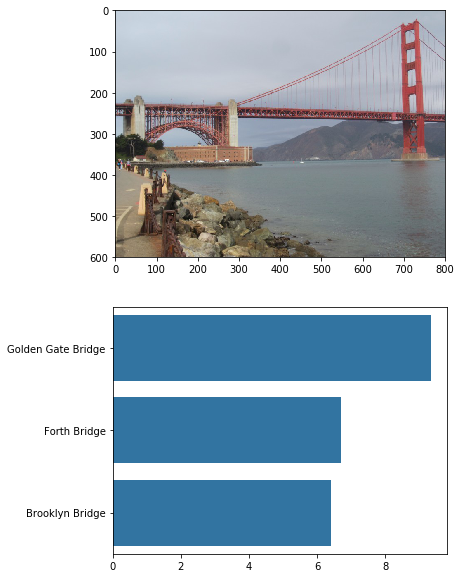

In [54]:
import seaborn as sns

def suggest_locations(img_path):

    path = img_path.split('/')
    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ')}")

    # get landmark predictions
    landmarks, confidence  = predict_landmarks(img_path, 3)
    print(f"Predicted Label: {landmarks[0]}")

    img = Image.open(img_path).convert('RGB')

    plt.figure(figsize = (6,10))

    ax = plt.subplot(2,1,1)
    ax.imshow(img)

    plt.subplot(2,1,2)
    sns.barplot(x=confidence, y=landmarks, color=sns.color_palette()[0]);
    plt.show()

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')




### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ After adding augmentation in transforms accuracy has increased from 21% to 25% even though I have reduced epoch from 100 to 60. So I feel now model accuracy is better than I expected.


Three possible points for improvement:

- 1) Validation loss was decreasing till 30 epoch to get 67% accuracy. So I guess, increasing number of epochs or increasing learn rate will increase accuracy towards 80% - 85%.

- 2) Using adam optimizer could further increase training time, but for now I could not do it as I need to save GPU time for further projects.

- 3) By using better transformers, like using some other augmentation process the performance can be increased further.

In [57]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.


import cv2
from PIL import Image
import requests

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


def predict_landmarks_url(url, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image=Image.open(requests.get(url, stream=True).raw)
    data = non_train_transform(image)
    data.unsqueeze_(0)
    if use_cuda:
        data = data.cuda()
    pred=model_transfer(data)
    values, indexes = pred.topk(k)
    
    indexes_np = indexes.cpu().numpy().flatten() ##convert tensor to 1D array (flatten is to convert from 1D to 2D)
                                               ## need to save it to cpu first to be able to use numpy() 

    values_np = values.cpu().detach().numpy().flatten() # need to detach values    
    names = []
        
    for index in indexes_np:
        name = classes[index].replace("_", " ")
        names.append(name)        
        
    return names, values_np

def suggest_locations_url(url):

    # get landmark predictions
    landmarks, confidence  = predict_landmarks_url(url, 3)
    print(f"Predicted Label: {landmarks[0]}")

    img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

    plt.figure(figsize = (6,10))

    ax = plt.subplot(2,1,1)
    ax.imshow(img)

    plt.subplot(2,1,2)
    sns.barplot(x=confidence, y=landmarks, color=sns.color_palette()[0]);
    plt.show()
    

# test on a sample image


Predicted Label: Golden Gate Bridge


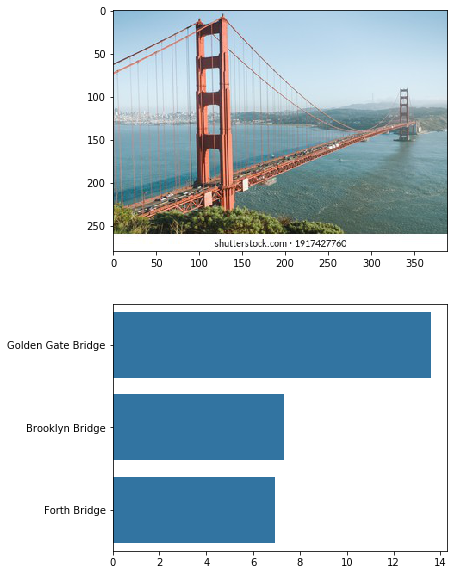

In [58]:
suggest_locations_url('https://image.shutterstock.com/image-photo/san-francisco-united-states-jan-260nw-1917427760.jpg')

Predicted Label: Grand Canyon


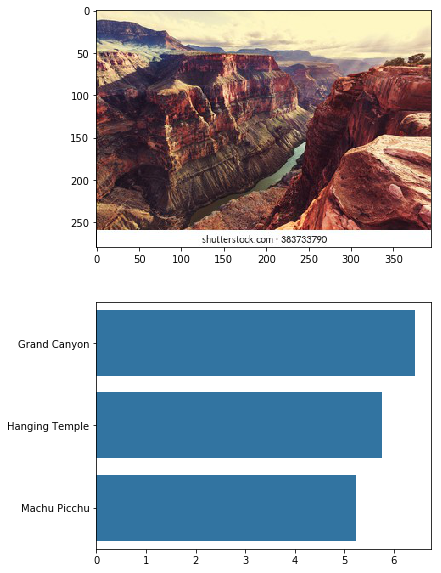

In [59]:
suggest_locations_url('https://image.shutterstock.com/image-photo/picturesque-landscapes-grand-canyon-260nw-383733790.jpg')

Predicted Label: Eiffel Tower


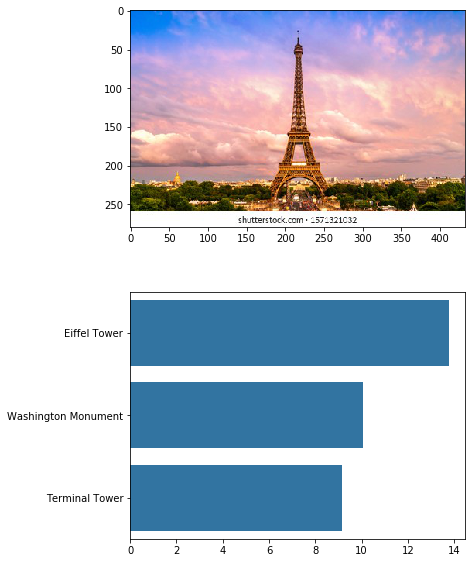

In [60]:
suggest_locations_url('https://image.shutterstock.com/image-photo/beautiful-view-famous-eiffel-tower-260nw-1571321032.jpg')

Predicted Label: Sydney Opera House


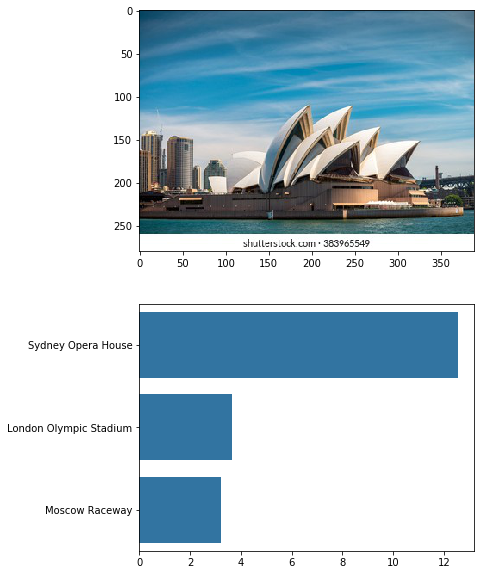

In [61]:
suggest_locations_url('https://image.shutterstock.com/image-photo/sydney-australia-november-10-2015-260nw-383965549.jpg')